In [ ]:
import os
os._exit(00)

In [1]:
import os
import gymnasium as gym
import pandas as pd
import numpy as np
import ray
import sys

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
sys.path.insert(0, "../../Autonomous_Fed/")
sys.path.insert(0, "../../Autonomous_Fed/scripts")

import ray
from ray import tune, serve, air
from ray.tune.registry import register_env
from ray.rllib.algorithms import ppo
from ray.rllib.algorithms.ppo import PPOConfig
from ray.rllib.algorithms.ddpg import DDPGConfig
from ray.rllib.algorithms.algorithm import Algorithm
from ray.rllib.models import ModelCatalog
from ray.rllib.policy.policy import Policy
from ray.rllib.utils.framework import try_import_tf, try_import_torch
from ray.util.placement_group import placement_group
from ray.util.scheduling_strategies import PlacementGroupSchedulingStrategy


from config import Config, print_colored_text
from env import AutonomousFed
from data_prep import gen_seq, series_to_supervised, plotting, DataPrep
from sim import TF_VAE_Model

tf1, tf, tfv = try_import_tf()
tf1.enable_eager_execution()

RAY_PICKLE_VERBOSE_DEBUG=1
os.environ['PYTHONWARNINGS'] = "ignore::DeprecationWarning"
os.environ['RAY_SERVE_QUEUE_LENGTH_RESPONSE_DEADLINE_S'] = '3'

In [2]:
# Paths to checkpoints, given penalty coefficient
checkpoints = {
    100: {
        'LR':{
            'non-linear':{
                'omegas-equal': '/Users/erotokritosskordilis/ray_results/PPO_2024-04-30_19-21-57/PPO_AutonomousFed_702bc_00000_0_2024-04-30_19-21-57/checkpoint_000039/policies/default_policy/',
                'omegas-not-equal': '/Users/erotokritosskordilis/ray_results/PPO_2024-04-30_19-35-37/PPO_AutonomousFed_593fc_00000_0_2024-04-30_19-35-37/checkpoint_000039/policies/default_policy/'
            },
            'linear':{
                'omegas-equal': '/Users/erotokritosskordilis/ray_results/PPO_2024-04-26_12-35-22/PPO_AutonomousFed_fa21b_00000_0_2024-04-26_12-35-22/checkpoint_000039/policies/default_policy/',
                'omegas-not-equal': '/Users/erotokritosskordilis/ray_results/PPO_2024-04-26_12-40-39/PPO_AutonomousFed_b7433_00000_0_2024-04-26_12-40-39/checkpoint_000039/policies/default_policy/'
            }
        },
        'RF':{
            'non-linear':{
                'omegas-equal': '/Users/erotokritosskordilis/ray_results/PPO_2024-04-30_19-44-08/PPO_AutonomousFed_89d4c_00000_0_2024-04-30_19-44-08/checkpoint_000099/policies/default_policy/',
                'omegas-not-equal': '/Users/erotokritosskordilis/ray_results/PPO_2024-04-30_20-04-49/PPO_AutonomousFed_6d82d_00000_0_2024-04-30_20-04-49/checkpoint_000099/policies/default_policy/'
            },
            'linear':{
                'omegas-equal': '/Users/erotokritosskordilis/ray_results/PPO_2024-04-26_13-38-48/PPO_AutonomousFed_d6696_00000_0_2024-04-26_13-38-48/checkpoint_000099/policies/default_policy/',
                'omegas-not-equal': '/Users/erotokritosskordilis/ray_results/PPO_2024-04-26_13-59-36/PPO_AutonomousFed_be7aa_00000_0_2024-04-26_13-59-36/checkpoint_000099/policies/default_policy/'
            }
        }
    },
    10: {
        'LR':{
            'non-linear':{
                'omegas-equal': '/Users/erotokritosskordilis/ray_results/PPO_2024-05-02_12-07-36/PPO_AutonomousFed_17bc2_00000_0_2024-05-02_12-07-36/checkpoint_000010/policies/default_policy/',
                'omegas-not-equal': '/Users/erotokritosskordilis/ray_results/PPO_2024-05-02_15-09-16/PPO_AutonomousFed_788e7_00000_0_2024-05-02_15-09-16/checkpoint_000010/policies/default_policy/'
            },
            'linear':{
                'omegas-equal': '/Users/erotokritosskordilis/ray_results/PPO_2024-05-01_19-39-23/PPO_AutonomousFed_0a308_00000_0_2024-05-01_19-39-23/checkpoint_000039/policies/default_policy/',
                'omegas-not-equal': '/Users/erotokritosskordilis/ray_results/PPO_2024-05-02_10-24-07/PPO_AutonomousFed_a2e71_00000_0_2024-05-02_10-24-07/checkpoint_000039/policies/default_policy/'
            }
        },
        'RF':{
            'non-linear':{
                'omegas-equal': '/Users/erotokritosskordilis/ray_results/PPO_2024-05-03_15-54-04/PPO_AutonomousFed_e51d1_00000_0_2024-05-03_15-54-04/checkpoint_000039/policies/default_policy/',
                'omegas-not-equal': '/Users/erotokritosskordilis/ray_results/PPO_2024-05-04_08-58-00/PPO_AutonomousFed_effdf_00000_0_2024-05-04_08-58-00/checkpoint_000039/policies/default_policy/'
            },
            'linear':{
                'omegas-equal': '/Users/erotokritosskordilis/ray_results/PPO_2024-05-02_17-20-52/PPO_AutonomousFed_dacaa_00000_0_2024-05-02_17-20-52/checkpoint_000039/policies/default_policy/',
                'omegas-not-equal': '/Users/erotokritosskordilis/ray_results/PPO_2024-05-03_11-56-57/PPO_AutonomousFed_c532b_00000_0_2024-05-03_11-56-57/checkpoint_000039/policies/default_policy/'
            }
        }
    },
    0: {
        'LR':{
            'non-linear':{
                'omegas-equal': '/Users/erotokritosskordilis/ray_results/PPO_2024-05-04_16-29-01/PPO_AutonomousFed_f12f3_00000_0_2024-05-04_16-29-01/checkpoint_000019/policies/default_policy/',
                'omegas-not-equal': '/Users/erotokritosskordilis/ray_results/PPO_2024-05-04_17-49-40/PPO_AutonomousFed_35a9b_00000_0_2024-05-04_17-49-40/checkpoint_000019/policies/default_policy/'
            },
            'linear':{
                'omegas-equal': '/Users/erotokritosskordilis/ray_results/PPO_2024-05-04_13-16-29/PPO_AutonomousFed_0b9b4_00000_0_2024-05-04_13-16-29/checkpoint_000039/policies/default_policy/',
                'omegas-not-equal': '/Users/erotokritosskordilis/ray_results/PPO_2024-05-04_15-00-54/PPO_AutonomousFed_a2332_00000_0_2024-05-04_15-00-54/checkpoint_000019/policies/default_policy/'
            }
        },
        'RF':{
            'non-linear':{
                'omegas-equal': '/Users/erotokritosskordilis/ray_results/PPO_2024-05-06_14-04-37/PPO_AutonomousFed_1a2d7_00000_0_2024-05-06_14-04-37/checkpoint_000039/policies/default_policy/',
                'omegas-not-equal': '/Users/erotokritosskordilis/ray_results/PPO_2024-05-06_17-43-42/PPO_AutonomousFed_b52d7_00000_0_2024-05-06_17-43-42/checkpoint_000039/policies/default_policy/'
            },
            'linear':{
                'omegas-equal': '/Users/erotokritosskordilis/ray_results/PPO_2024-05-05_10-55-54/PPO_AutonomousFed_92697_00000_0_2024-05-05_10-55-54/checkpoint_000039/policies/default_policy/',
                'omegas-not-equal': '/Users/erotokritosskordilis/ray_results/PPO_2024-05-06_11-02-57/PPO_AutonomousFed_b9452_00000_0_2024-05-06_11-02-57/checkpoint_000039/policies/default_policy/'
            }
        }
    }
}


In [52]:
# Choose the checkpoint as input from the keyboard
penalty = int(input('Enter coefficient (100/10/0): '))
model = input('Enter model type (LR/RF): ').upper()
policy = input('Enter policy type (linear/non-linear): ')
omegas = input('Enter omegas relationship (omegas-equal/omegas-not-equal): ')

omega_vals = [0.5, 0.125] if omegas == "omegas-not-equal" else [0.5, 0.5]

(raylet) [2024-05-12 15:27:58,630 E 19423 33453277] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-12_15-27-36_754831_4438 is over 95% full, available space: 9856847872; capacity: 245107195904. Object creation will fail if spilling is required.


Enter coefficient (100/10/0):  100
Enter model type (LR/RF):  rf
Enter policy type (linear/non-linear):  non-linear
Enter omegas relationship (omegas-equal/omegas-not-equal):  omegas-not-equal


2024-05-12 15:28:12,240	INFO worker.py:1743 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


Choose specifications set {A, B, C}:  a


[0.5, 0.125]


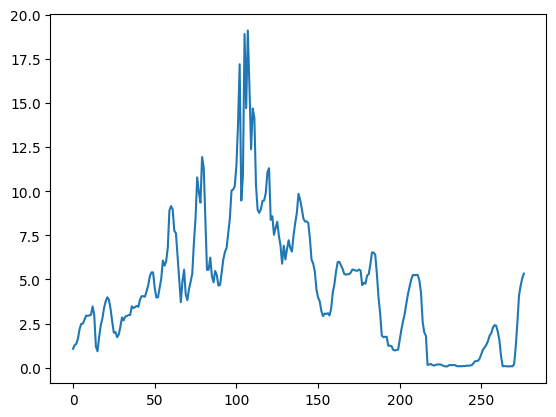

In [53]:
if ray.is_initialized():
    ray.shutdown()

ray.init(num_cpus=os.cpu_count())

specifications_set = input("Choose specifications set {A, B, C}: ").upper()
print(omega_vals)

simulator = model

if simulator == 'VAE':
    # Initialize Ray Serve
    serve.start()

    # Load the models based on the specifications set
    encoder_path = os.path.join('../../Autonomous_Fed/saved_models/',f'encoder_FedModel_{specifications_set}.keras')
    decoder_path = os.path.join('../../Autonomous_Fed/saved_models/',f'decoder_FedModel_{specifications_set}.keras')
    path = [encoder_path, decoder_path]

    # Deploy the models
    #TF_VAE_Model.deploy(path)
    serve.run(target=TF_VAE_Model.bind(path),logging_config={"log_level": "ERROR"})

df, df_interest_rate, scaler = DataPrep().read_data(specifications_set=specifications_set)

env_config = {'start_date': '1954-07-01', 
              'end_date': '2023-07-01', 
              'action_specifications': 'ir_omegas_fixed',
              'simulator': simulator, 
              'omega_pi': omega_vals[0],
              'omega_psi': omega_vals[1],
              'specifications_set': specifications_set,
              'use_penalty': True,
              'normalization_scheme': 'minmax',
              'df': [df, df_interest_rate],
              'scaler': scaler,
              'model_config': Config(),
              'training_setting': False}

env_name = "AutonomousFed"
register_env(env_name, lambda config: AutonomousFed(env_config))

config = ppo.PPOConfig().\
    environment(env=env_name, 
                env_config = env_config,
                observation_space = gym.spaces.Box(low=-100.0, high=100.0, shape=(2,), dtype=np.float32),
                action_space= gym.spaces.Box(low=0.0, high=100.0, shape=(1,), dtype=np.float32),
                disable_env_checking=True,
                clip_actions=True).\
        rollouts(num_rollout_workers=0)
config = config.framework("tf2")
config = config.to_dict()
config["num_workers"] = 0

In [54]:
# Use the `from_checkpoint` utility of the Policy class:
chckpt = checkpoints[penalty][model][policy][omegas]
print(chckpt)

my_restored_policy = Policy.from_checkpoint(chckpt)

/Users/erotokritosskordilis/ray_results/PPO_2024-04-30_20-04-49/PPO_AutonomousFed_6d82d_00000_0_2024-04-30_20-04-49/checkpoint_000099/policies/default_policy/


In [55]:
from env import AutonomousFed

env = AutonomousFed(env_config)

RF


In [56]:
epsilon = 1e-10

obs, info = env.reset()
obs

array([0.72722   , 5.62437582])

In [57]:
results_all_equals = {'inflation':[],
                      'GDP_gap':[],
                      'interest_rate':[]}
terminated = False
while not terminated:
    action = my_restored_policy.compute_single_action(obs, clip_action=True,explore=False)
    obs, reward, terminated, truncated, info = env.step(action[0])
    results_all_equals['inflation'].append(obs[0])
    results_all_equals['GDP_gap'].append(obs[1])
    results_all_equals['interest_rate'].append(max(action[0][0],0))
    print(obs, action[0][0])

[1.25477798 6.11618106] 1.8160423
[1.41826079 7.09673818] 1.8162998
[1.59060012 9.63086285] 1.8163742
[ 2.23564965 11.33959397] 1.8163863
[ 2.31930271 11.55738632] 1.816408
[ 3.09403974 10.62817408] 1.8164092
[ 3.29520081 10.34851873] 1.8164204
[ 3.45284402 10.21034042] 1.8164214
[3.54623369 9.42228768] 1.8164216
[ 3.3250729  10.39329133] 1.8164219
[ 3.60204161 10.19635609] 1.8164214
[3.36149129 8.97543944] 1.8164219
[3.06102243 8.80927804] 1.8164216
[2.88347924 6.7939655 ] 1.8164209
[1.85162079 4.03500741] 1.816383
[1.76795393 3.90517845] -2.4796035
[1.93110126 5.71117112] -2.4796038
[2.16120207 6.09212269] 1.8159038
[1.64290117 7.52880009] 1.8163162
[1.60036167 8.19911566] 1.8163954
[1.59152429 7.72529601] 1.8163925
[1.41209983 6.5966703 ] 1.8163923
[1.61502538 7.89035952] 1.816362
[1.57795582 5.99787776] 1.8163937
[1.5611217 5.8566764] 1.8163232
[1.52671894 3.91312086] 1.8162798
[1.43537299 3.76373775] -2.479589
[1.44103587 4.08107078] -2.479595
[1.20453442 5.96679939] -2.479234
[1.

(raylet) [2024-05-12 15:28:21,135 E 19483 33454173] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-12_15-28-09_376615_4438 is over 95% full, available space: 9855512576; capacity: 245107195904. Object creation will fail if spilling is required.


[3.16596591 6.65390282] 1.8073243
[3.25806003 6.69209869] 1.8035611
[3.34546167 7.45981821] 1.7411536
[3.54991041 7.40773479] 1.8164107
[3.64179399 8.03970334] 1.8163482
[3.89624149 8.31657248] 1.8164185
[3.91047449 8.28757997] 1.8164185
[3.42004181 8.05654329] 1.8164178
[3.45402702 7.42089892] 1.81642
[3.37780152 7.6443661 ] 1.8163952
[3.45590364 7.37526298] 1.8164161
[3.5001477  6.19592469] 1.816384
[3.25833915 5.48238901] -2.4795926
[2.80021201 3.89145261] -2.479606
[2.77353834 3.90569126] -2.4796064
[2.76602116 3.92856515] -2.4796064
[2.51337979 4.01918111] -2.4796064
[2.02545439 4.41277661] -2.4796064
[1.92213647 5.46232593] -2.4795957
[1.99707473 5.80742278] 1.8101367
[2.01783142 5.87764719] 1.8160793
[2.01964441 5.7336395 ] 1.8161906
[2.01588669 5.71129789] 1.8157219
[2.00311185 5.48324404] 1.8155826
[2.06149592 5.90296829] 1.8042327
[2.0158576  5.97875543] 1.8161896
[2.00526548 6.12212039] 1.8162922
[2.00526548 6.12212039] 1.8163532
[1.98700651 6.81138264] 1.8163532
[1.99274793

In [58]:
df = pd.DataFrame(results_all_equals)
df.to_csv('../../Autonomous_Fed/scripts/results/'+str(penalty)+'_'+str(model)+'_'+str(policy)+'_'+str(omegas)+'.csv')

(raylet) [2024-05-12 15:28:31,234 E 19483 33454173] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-12_15-28-09_376615_4438 is over 95% full, available space: 9855176704; capacity: 245107195904. Object creation will fail if spilling is required.
(raylet) [2024-05-12 15:28:41,314 E 19483 33454173] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-12_15-28-09_376615_4438 is over 95% full, available space: 9855217664; capacity: 245107195904. Object creation will fail if spilling is required.
(raylet) [2024-05-12 15:28:51,319 E 19483 33454173] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-12_15-28-09_376615_4438 is over 95% full, available space: 9854189568; capacity: 245107195904. Object creation will fail if spilling is required.
(raylet) [2024-05-12 15:29:01,412 E 19483 33454173] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-12_15-28-09_376615_4438 is over 95% full, available space: 9851273216; capacity: 245107195904. Object crea